In [1]:
%load_ext autoreload
%autoreload 2
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

from src.models.training.train import TrainModule
from src.loop_calling.dataset.loop_dataset import LoopDataset
from src.utils import predict_matrix, plot_and_save_matrices, load_bigwig_signal
from src.ledidi.edit_tasks import evaluate_sym_to_asym
from src.ledidi.utils import report_nt_changes
from src.ledidi.utils import plot_multi_site_attributions

/cluster/work/boeva/shoenig/conda/envs/chiron/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [2]:
%%capture
CKPT="../data/chiron-model.ckpt"
model = TrainModule.load_from_checkpoint(CKPT)
model.eval()
model.to("cuda")

In [3]:
dataset = LoopDataset(
        regions_file_path="../data/extruding_loops.csv",
        cool_file_path="../data/A673_WT_CTCF_5000.cool",
        fasta_dir="../data/chromosomes",
        genomic_feature_path=None,
        mode="test",
        val_chroms=[],
        test_chroms=["chr2", "chr6", "chr19"],
        use_pretrained_backbone=True
    )

In [5]:
elem = dataset[946]
pred = predict_matrix(elem, model, 'cuda')

In [6]:
elem["idx"] = 946

In [8]:
evaluate_sym_to_asym(elem, model, device="cuda", stripe="X,Y", run_dir="ex2")

[SYM→ASYM] start
[SYM→ASYM] ratio=1.038, loss=28.926
iter=I	input_loss=0.0	output_loss=28.93	total_loss=28.93	time=0.0
iter=100	input_loss=1.566e+03	output_loss= 0.0	total_loss=31.32	time=40.9
iter=200	input_loss=1.026e+03	output_loss= 0.0	total_loss=20.52	time=40.76
iter=300	input_loss=324.0	output_loss= 0.0	total_loss=6.48	time=40.77
iter=400	input_loss=270.0	output_loss= 0.0	total_loss= 5.4	time=40.75
iter=500	input_loss=393.0	output_loss= 0.0	total_loss=7.86	time=40.74
iter=600	input_loss=194.0	output_loss=0.0406	total_loss=3.921	time=40.74
iter=700	input_loss=111.0	output_loss= 0.0	total_loss=2.22	time=40.71
iter=800	input_loss=133.0	output_loss= 0.0	total_loss=2.66	time=40.75
iter=900	input_loss=143.0	output_loss= 0.0	total_loss=2.86	time=40.86
iter=1000	input_loss=161.0	output_loss= 0.0	total_loss=3.22	time=40.99
iter=1100	input_loss=174.0	output_loss= 0.0	total_loss=3.48	time=40.98
iter=1200	input_loss=187.0	output_loss= 0.0	total_loss=3.74	time=40.99
iter=1300	input_loss=309.0

In [18]:
evaluate_sym_to_asym(elem, model, threshold=0.2, device="cuda", stripe="X,Y", run_dir="ex2")

Starting Run
iter=I	input_loss=0.0	output_loss=28.92	total_loss=28.92	time=0.0
iter=100	input_loss=1.098e+03	output_loss= 0.0	total_loss=21.96	time=40.94
iter=200	input_loss=461.0	output_loss= 0.0	total_loss=9.22	time=41.04
iter=300	input_loss=236.0	output_loss= 0.0	total_loss=4.72	time=41.06
iter=400	input_loss=317.0	output_loss= 0.0	total_loss=6.34	time=41.03
iter=500	input_loss=391.0	output_loss= 0.0	total_loss=7.82	time=41.02
iter=600	input_loss=249.0	output_loss= 0.0	total_loss=4.98	time=40.95
iter=700	input_loss=309.0	output_loss= 0.0	total_loss=6.18	time=41.0
iter=800	input_loss=151.0	output_loss= 0.0	total_loss=3.02	time=41.07
iter=900	input_loss=174.0	output_loss=0.1185	total_loss=3.598	time=41.11
iter=1000	input_loss=166.0	output_loss= 0.0	total_loss=3.32	time=41.16
iter=1100	input_loss=298.0	output_loss= 0.0	total_loss=5.96	time=41.15
iter=1200	input_loss=115.0	output_loss= 0.0	total_loss= 2.3	time=41.06
iter=1300	input_loss=249.0	output_loss= 0.0	total_loss=4.98	time=41.1
i

{'idx': 946,
 'loop_start': 241170000,
 'loop_end': 241380000,
 'stripe': 'X,Y',
 'original_ratio': 1.0377700328826904,
 'edited_ratio': 0.6291365027427673,
 'mutations_raw': [367863],
 'mutations_final': [367863],
 'base_changes': ['G>C'],
 'single_edit_contrib': None,
 'chr': 'chr2',
 'contributions': []}

In [10]:
edited_sequence = torch.load("./ex2/chr2/best_onehot_946.pt")

In [11]:
deep_copy = copy.deepcopy(elem)
deep_copy['sequence'] = edited_sequence
pred_all = predict_matrix(deep_copy, model, 'cuda')

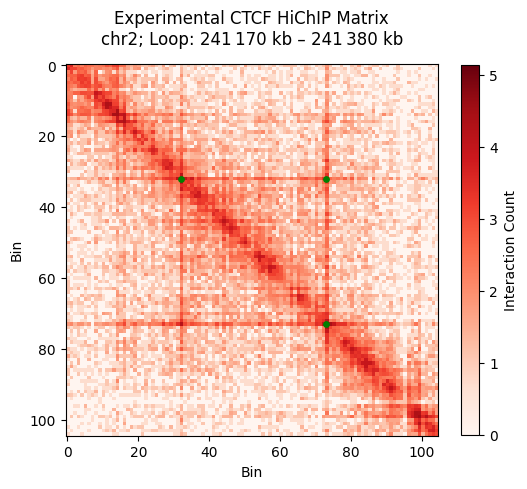

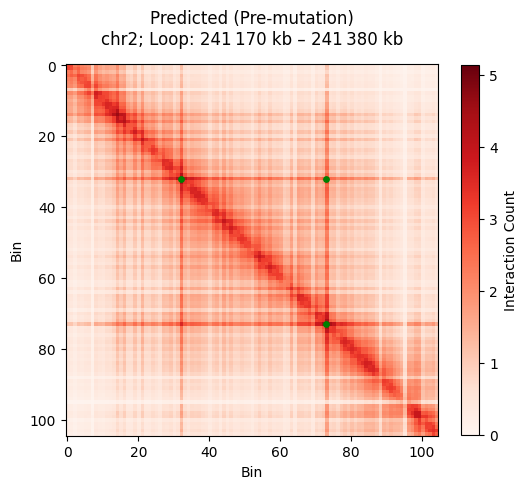

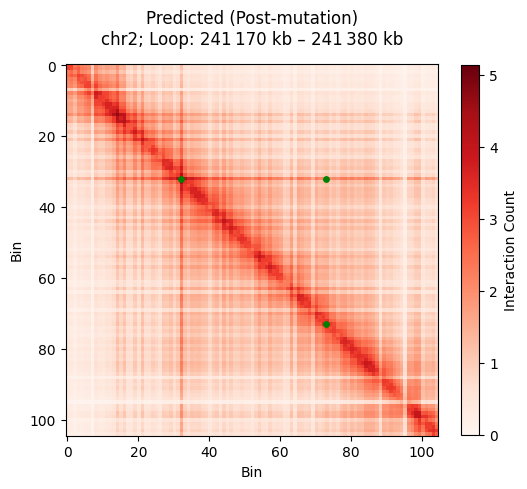

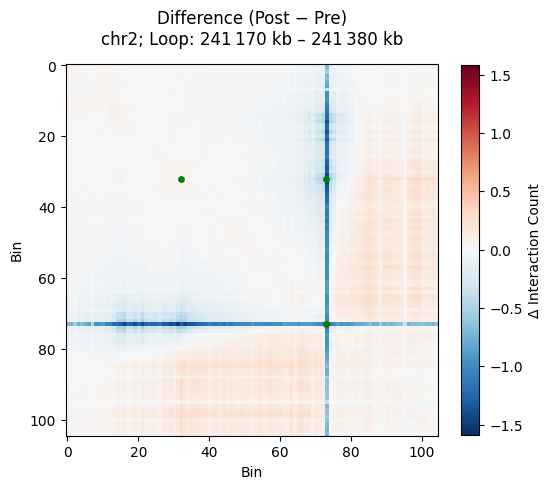

{'exp': '946/Sym_To_Asym_exp.png',
 'pre': '946/Sym_To_Asym_pred_pre.png',
 'post': '946/Sym_To_Asym_pred_post.png',
 'diff': '946/Sym_To_Asym_diff.png'}

In [12]:
%matplotlib inline
plot_and_save_matrices(elem, pred, pred_all, save_dir="946", prefix="Sym_To_Asym", show=True)

In [13]:
edits = report_nt_changes(elem["sequence"], deep_copy["sequence"])

Total sequence-positions with any mismatch: 1
367858: C → A


In [15]:
def plot_ctcf(elem, start, end, mark_start, mark_end):
    chrom = elem["chr"]
    signal = load_bigwig_signal("/cluster/work/boeva/shoenig/ews-ml/data/corigami/raw/A673_WT/genomic_features_data/CTCF/A673_WT_CTCF_coverage_FE.bw", chrom, start, end)
    x = np.arange(start, end)
    x = np.linspace(start, end, num=len(signal), endpoint=False)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, signal)
    ax.set_ylabel("Signal")
    ax.set_title("CTCF track")
    ax.set_xlim(start, end)
    
    if (mark_start is not None) and (mark_end is not None):
        hs, he = max(mark_start, start), min(mark_end, end)
        if hs < he:
            ax.axvspan(hs, he, alpha=0.2)
            ax.axvline(hs, linestyle="--", linewidth=0.8)
            ax.axvline(he, linestyle="--", linewidth=0.8)
    
    fig.tight_layout()

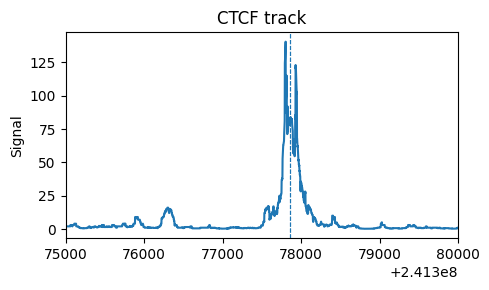

In [16]:
plot_ctcf(elem, elem["region_start"]+365000, elem["region_start"]+370000, elem["region_start"]+367858-1, elem["region_start"]+367858+1)

/cluster/work/boeva/shoenig/RECOMB/Chiron3D/src/ledidi/utils.py:214: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  ymin = float(torch.min(torch.min(orig_slice), torch.min(upd_slice)))


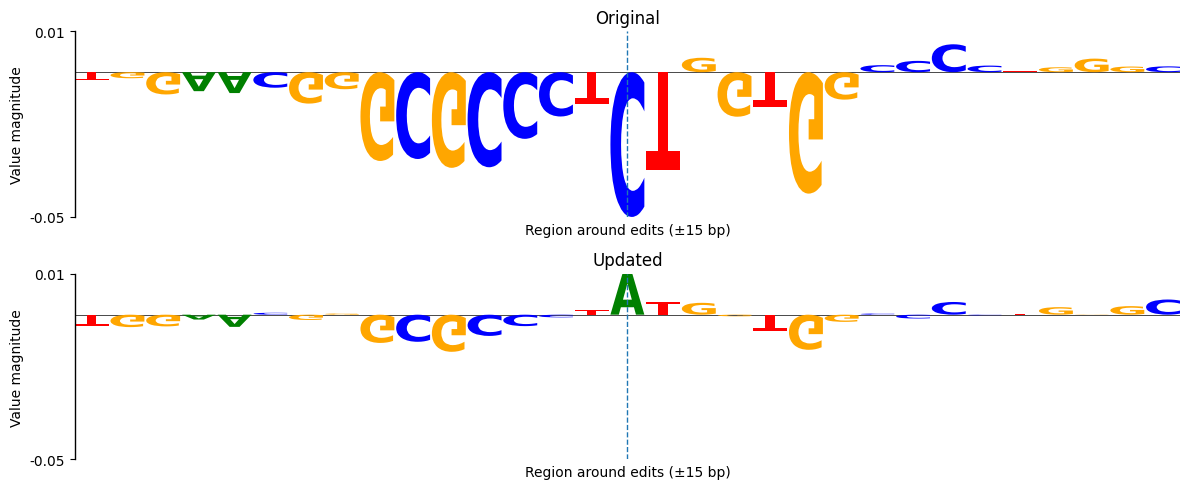

In [17]:
plot_multi_site_attributions(model, elem, edits, window_radius=15)